In [31]:

import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

from torch.utils.data import Dataset
class SevenScenesNNDataset(Dataset):
    def __init__(self, root_dir, pairs_file, mast3r_output=None, max_index=None):
        self.root_dir = root_dir
        self.scenes_dict = {i: scene for i, scene in enumerate(['chess', 'fire', 'heads', 'office', 'pumpkin', 'redkitchen', 'stairs'])}
        
        self.query_paths, self.anchor_paths, self.scene_ids = self._read_pairs_txt(pairs_file, max_index)
        if mast3r_output:
            self.mast3r_q2a, self.mast3r_query_poses = self._read_results_txt(mast3r_output, max_index)
        else:
            self.mast3r_q2a, self.mast3r_query_poses = None, None
        
    def _read_pairs_txt(self, pairs_file, max_index=None):
        query_paths, anchor_paths, scene_ids = [], [], []
        with open(pairs_file, 'r') as f:
            for i, line in enumerate(f):
                if max_index is not None and i >= max_index:
                    break
                anchors = []
                chunks = line.strip().split(' ')
                scene_id = chunks[-1]
                
                scene_ids.append(scene_id)
                query_paths.append(os.path.join(self.root_dir, self.scenes_dict[int(scene_id)], chunks[0][1:]))
                for j in range(1,10):
                    anchors.append(os.path.join(self.root_dir, self.scenes_dict[int(scene_id)], chunks[8*j][1:]))
                anchor_paths.append(anchors)

        return query_paths, anchor_paths, scene_ids

    def _read_results_txt(self, results_file, max_index=None):
        mast3r_q2a = {}
        mast3r_query_poses = {}
        with open(results_file, 'r') as f:
            for i, line in enumerate(f):
                if max_index is not None and i >= max_index:
                    break
                chunks = line.strip().split(' ')
                query_path = chunks[0]
                transforms = []
                poses = []
                for j in range(9):  # 9 anchors
                    start_transform = 1 + j * 32
                    end_transform = start_transform + 16
                    start_pose = end_transform
                    end_pose = start_pose + 16
                    
                    if chunks[start_transform:end_transform]:
                        transform = np.array([float(x) for x in chunks[start_transform:end_transform]]).reshape(4, 4)
                        pose = np.array([float(x) for x in chunks[start_pose:end_pose]]).reshape(4, 4)
                        transforms.append(transform)
                        poses.append(pose)
                    else:
                        transforms.append(None)
                        poses.append(None)
                
                mast3r_q2a[query_path] = transforms
                mast3r_query_poses[query_path] = poses
        return mast3r_q2a, mast3r_query_poses
    
    def _load_pose(self, image_path):
        pose_path = image_path.replace('.color.png', '.pose.txt')
        pose = np.loadtxt(pose_path)
        return pose
    
    def __getitem__(self, idx):
        query_path = self.query_paths[idx]
        anchors_path = self.anchor_paths[idx]
        scene_id = self.scene_ids[idx]
        query_pose = self._load_pose(query_path)
        anchor_poses = []
        for anchor in anchors_path:
            anchor_poses.append(np.array(self._load_pose(anchor)))

        mast3r_q2a = self.mast3r_q2a[query_path] if self.mast3r_q2a else [None] * 9
        mast3r_query_pose = self.mast3r_query_poses[query_path] if self.mast3r_query_poses else [None] * 9

        return{
            'query_path': query_path,
            'anchors_path': anchors_path,
            'scene_id': scene_id,
            'gt_query_pose': np.array(query_pose),
            'anchor_poses': anchor_poses,
            'mast3r_q2a': mast3r_q2a,
            'mast3r_query_pose': mast3r_query_pose

        }
    def __len__(self):
        return len(self.query_paths)
    
    def show_query_and_anchors(self, idx, anchor_idx=None):
        data = self[idx]
        query_path = data['query_path']
        anchors_path = data['anchors_path']

        query_img = Image.open(query_path).convert('RGB')

        if anchor_idx is not None:
            # Display query and specific anchor
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
            ax1.imshow(query_img)
            ax1.set_title('Query Image')
            ax1.axis('off')

            anchor_img = Image.open(anchors_path[anchor_idx]).convert('RGB')
            ax2.imshow(anchor_img)
            ax2.set_title(f'Anchor Image {anchor_idx}')
            ax2.axis('off')

        else:
            # Display query and all anchors
            fig, axes = plt.subplots(3, 4, figsize=(4, 3))
            axes = axes.flatten()

            axes[0].imshow(query_img)
            axes[0].set_title('Query Image')
            axes[0].axis('off')

            for i, anchor_path in enumerate(anchors_path):
                anchor_img = Image.open(anchor_path).convert('RGB')
                axes[i+1].imshow(anchor_img)
                axes[i+1].set_title(f'Anchor {i}')
                axes[i+1].axis('off')

            # Remove extra subplots
            for i in range(len(anchors_path) + 1, 12):
                fig.delaxes(axes[i])

        plt.tight_layout()
        plt.show()


    

In [32]:
dataset = SevenScenesNNDataset('/datasets/7scenes_org', 
                               '/home/bjangley/VPR/7scenes/pairs2/test_tuples_multiimagerelposenet.txt',
                               mast3r_output='/home/bjangley/VPR/7scenes/pairs2/results_dud2.txt',
                               max_index=315)

print(len(dataset))




315


In [78]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np

def plot_arrow(ax, pose, color, label):
    position = pose[:3, 3]
    direction = pose[:3, 2]  # The third column of the rotation matrix gives the forward direction
    ax.quiver(position[0], position[2], direction[0], direction[2], 
              color=color, scale=3, scale_units='inches', label=label)

def plot_query(frame, dataset):
    fig, ax = plt.subplots(figsize=(10, 8))
    data = dataset[frame]
    
    query_pose = data['gt_query_pose']
    ax.scatter(query_pose[0, 3], query_pose[2, 3], c='r', s=100, label='Query')
    plot_arrow(ax, query_pose, 'r', 'Query Direction')
    
    anchor_x, anchor_z = [], []
    estimated_x, estimated_z = [], []
    
    for i, (anchor_pose, master_query_pose) in enumerate(zip(data['anchor_poses'], data['mast3r_query_pose'])):
        if master_query_pose is not None:
            ax.plot([anchor_pose[0, 3], master_query_pose[0, 3]],
                    [anchor_pose[2, 3], master_query_pose[2, 3]], 'k--')
            anchor_x.append(anchor_pose[0, 3])
            anchor_z.append(anchor_pose[2, 3])
            estimated_x.append(master_query_pose[0, 3])
            estimated_z.append(master_query_pose[2, 3])

            
            # Plot arrow for anchor
            plot_arrow(ax, anchor_pose, 'b', 'Anchor Direction' if i == 0 else '')
            
            # Plot arrow for estimated query pose
            plot_arrow(ax, master_query_pose, 'g', 'Estimated Direction' if i == 0 else '')
    
    ax.scatter(anchor_x, anchor_z, c='b', s=10, label='Anchor')
    ax.scatter(estimated_x, estimated_z, c='g', s=10, label='Estimated')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.legend()
    ax.grid(True)
    ax.set_title(f'Query {frame}')
    plt.show()

def visualize_poses(dataset):
    interact(plot_query, frame=widgets.IntSlider(min=0, max=len(dataset)-1, step=1, value=0), dataset=widgets.fixed(dataset))

# Usage
visualize_poses(dataset)


interactive(children=(IntSlider(value=0, description='frame', max=314), Output()), _dom_classes=('widget-inter…

Evaluating poses: 0it [00:00, ?it/s]

Evaluating poses: 419it [00:00, 1177.45it/s]


Median position error: 0.228 meters
Median rotation error: 3.390 degrees
Mean position error: 0.292 meters
Mean rotation error: 5.579 degrees


Processing locations: 419it [00:00, 2275.41it/s]


Number of queries: 3763
Number of estimates: 3763
Number of large errors (>0.3m): 1089


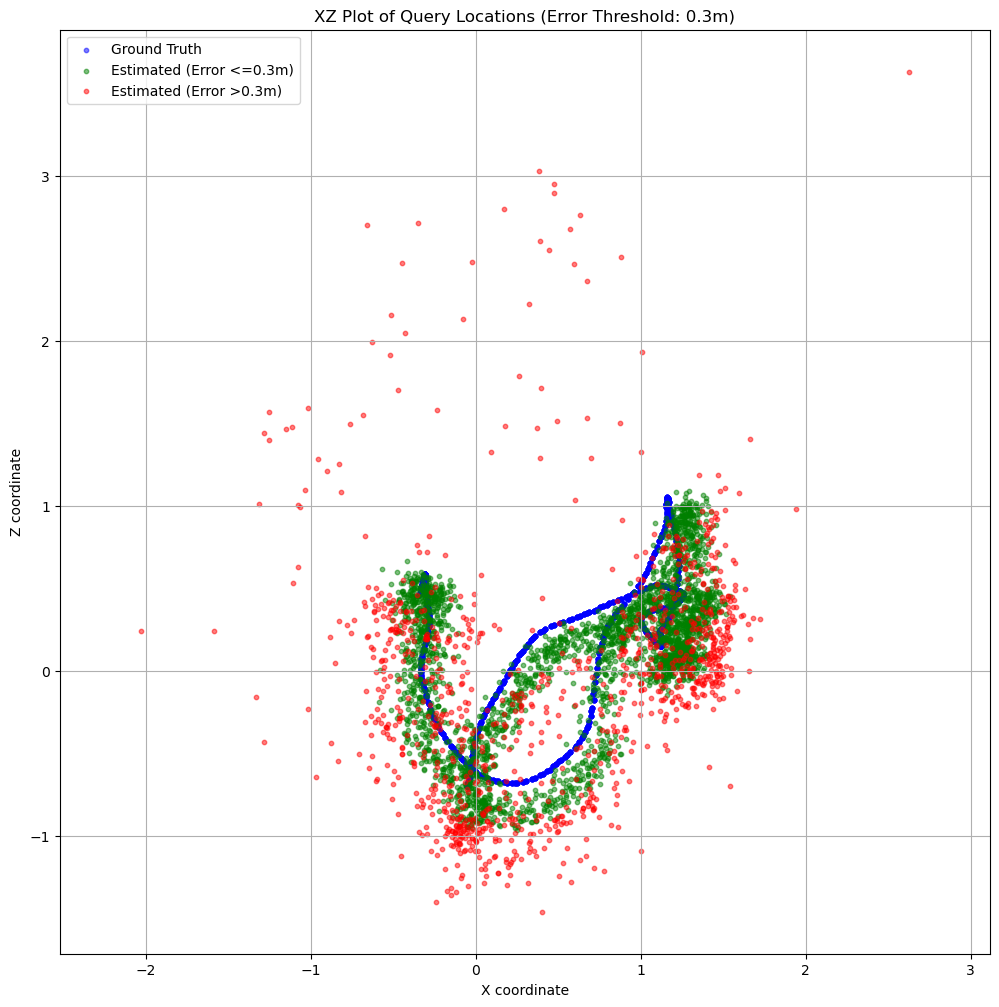

XZ plot displayed

Query and anchor indices with position error > 0.3m:
Query 0, Anchor 0
Query 0, Anchor 1
Query 0, Anchor 2
Query 0, Anchor 4
Query 0, Anchor 5
Query 0, Anchor 6
Query 0, Anchor 7
Query 0, Anchor 8
Query 1, Anchor 0
Query 1, Anchor 1
Query 1, Anchor 3
Query 1, Anchor 4
Query 1, Anchor 5
Query 1, Anchor 6
Query 1, Anchor 7
Query 2, Anchor 1
Query 2, Anchor 3
Query 2, Anchor 4
Query 2, Anchor 6
Query 2, Anchor 8
Query 3, Anchor 6
Query 3, Anchor 7
Query 3, Anchor 8
Query 4, Anchor 0
Query 4, Anchor 4
Query 4, Anchor 5
Query 4, Anchor 7
Query 5, Anchor 0
Query 5, Anchor 3
Query 5, Anchor 5
Query 5, Anchor 7
Query 6, Anchor 1
Query 6, Anchor 4
Query 6, Anchor 6
Query 6, Anchor 8
Query 7, Anchor 0
Query 7, Anchor 1
Query 7, Anchor 2
Query 7, Anchor 3
Query 7, Anchor 5
Query 7, Anchor 6
Query 8, Anchor 0
Query 8, Anchor 1
Query 8, Anchor 2
Query 8, Anchor 3
Query 8, Anchor 5
Query 9, Anchor 0
Query 9, Anchor 1
Query 9, Anchor 2
Query 9, Anchor 3
Query 9, Anchor 4
Query 9, A

Evaluating poses: 316it [00:00, 1282.27it/s]


Median position error: 0.256 meters
Median rotation error: 4.186 degrees
Mean position error: 0.608 meters
Mean rotation error: 21.274 degrees


Processing locations: 316it [00:00, 2329.02it/s]


Number of queries: 2838
Number of estimates: 2838
Number of large errors (>0.3m): 1186


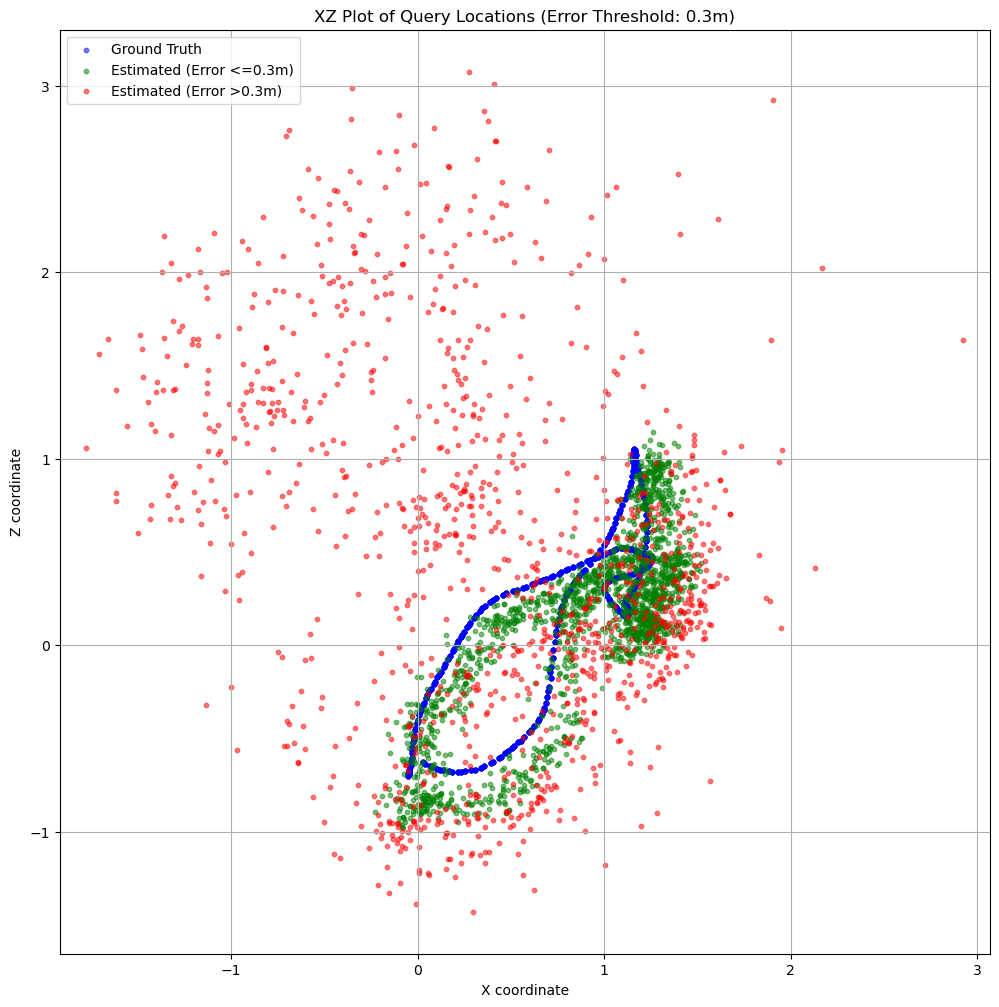

XZ plot displayed

Query and anchor indices with position error > 0.3m:
Query 0, Anchor 0
Query 0, Anchor 2
Query 0, Anchor 3
Query 0, Anchor 4
Query 0, Anchor 5
Query 0, Anchor 6
Query 0, Anchor 7
Query 0, Anchor 8
Query 1, Anchor 0
Query 1, Anchor 3
Query 1, Anchor 5
Query 1, Anchor 6
Query 1, Anchor 7
Query 2, Anchor 1
Query 2, Anchor 2
Query 2, Anchor 3
Query 2, Anchor 4
Query 2, Anchor 5
Query 2, Anchor 6
Query 2, Anchor 7
Query 2, Anchor 8
Query 3, Anchor 2
Query 3, Anchor 6
Query 3, Anchor 7
Query 3, Anchor 8
Query 4, Anchor 4
Query 4, Anchor 5
Query 4, Anchor 7
Query 5, Anchor 0
Query 5, Anchor 3
Query 5, Anchor 4
Query 5, Anchor 7
Query 6, Anchor 1
Query 6, Anchor 6
Query 6, Anchor 8
Query 7, Anchor 0
Query 7, Anchor 1
Query 7, Anchor 2
Query 7, Anchor 3
Query 7, Anchor 4
Query 7, Anchor 5
Query 7, Anchor 6
Query 7, Anchor 8
Query 8, Anchor 0
Query 8, Anchor 1
Query 8, Anchor 2
Query 8, Anchor 3
Query 8, Anchor 5
Query 9, Anchor 0
Query 9, Anchor 1
Query 9, Anchor 2
Query 9, A

In [36]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
import matplotlib.pyplot as plt

def compute_pose_error(est_pose, gt_pose):
    # Compute positional error
    pos_error = np.linalg.norm(est_pose[:3, 3] - gt_pose[:3, 3])
    
    est_quat = R.from_matrix(est_pose[:3, :3]).as_quat()
    gt_quat = R.from_matrix(gt_pose[:3, :3]).as_quat()
    est_quat = np.concatenate(([est_quat[3]], est_quat[:3]))
    gt_quat = np.concatenate(([gt_quat[3]], gt_quat[:3]))
    # Compute the quaternion dot product and account for double covering.
    dot = np.clip(np.abs(np.dot(est_quat, gt_quat)), -1.0, 1.0)
    theta = 2 * np.arccos(dot)
    
    rot_error = np.degrees(theta)

    # # Compute rotational error
    # R_diff = np.dot(est_pose[:3, :3], gt_pose[:3, :3].T)
    # rot_error = np.degrees(np.arccos((np.trace(R_diff) - 1) / 2))
    
    return pos_error, rot_error


def evaluateresults(dataset, results_file, error_threshold):
    pos_errors = []
    rot_errors = []
    large_error_indices = []
    
    with open(results_file, 'r') as f:
        for query_idx, line in enumerate(tqdm(f, desc="Evaluating poses")):
            chunks = line.strip().split()
            query_path = chunks[0]
            
            gt_pose = dataset._load_pose(query_path)
            
            for anchor_idx in range(9):
                start_idx = 1 + anchor_idx * 32
                end_idx = start_idx + 32
                transform_and_pose = chunks[start_idx:end_idx]
                
                if not all(float(x) == 0 for x in transform_and_pose[16:]):
                    mast3r_query_pose = np.array([float(x) for x in transform_and_pose[16:]]).reshape(4, 4)
                    pos_error, rot_error = compute_pose_error(mast3r_query_pose, gt_pose)
                    pos_errors.append(pos_error)
                    rot_errors.append(rot_error)
                    
                    if pos_error > error_threshold:
                        large_error_indices.append((query_idx, anchor_idx))
    
    return pos_errors, rot_errors, large_error_indices

def plot_xz_locations(dataset, results_file, large_error_indices, error_threshold):
    gt_x, gt_z = [], []
    est_x, est_z = [], []
    large_error_x, large_error_z = [], []
    
    with open(results_file, 'r') as f:
        for query_idx, line in enumerate(tqdm(f, desc="Processing locations")):
            chunks = line.strip().split()
            query_path = chunks[0]
            
            gt_pose = dataset._load_pose(query_path)
            
            for anchor_idx in range(9):
                start_idx = 1 + anchor_idx * 32
                end_idx = start_idx + 32
                transform_and_pose = chunks[start_idx:end_idx]
                
                if not all(float(x) == 0 for x in transform_and_pose[16:]):
                    mast3r_query_pose = np.array([float(x) for x in transform_and_pose[16:]]).reshape(4, 4)
                    
                    if (query_idx, anchor_idx) in large_error_indices:
                        large_error_x.append(mast3r_query_pose[0, 3])
                        large_error_z.append(mast3r_query_pose[2, 3])
                    else:
                        est_x.append(mast3r_query_pose[0, 3])
                        est_z.append(mast3r_query_pose[2, 3])
                    
                    gt_x.append(gt_pose[0, 3])
                    gt_z.append(gt_pose[2, 3])
    
    print(f"Number of queries: {len(gt_x)}")
    print(f"Number of estimates: {len(est_x) + len(large_error_x)}")
    print(f"Number of large errors (>{error_threshold}m): {len(large_error_x)}")
    
    plt.figure(figsize=(12, 12))
    plt.scatter(gt_x, gt_z, c='blue', label='Ground Truth', alpha=0.5, s=10)
    plt.scatter(est_x, est_z, c='green', label=f'Estimated (Error <={error_threshold}m)', alpha=0.5, s=10)
    plt.scatter(large_error_x, large_error_z, c='red', label=f'Estimated (Error >{error_threshold}m)', alpha=0.5, s=10)
    plt.xlabel('X coordinate')
    plt.ylabel('Z coordinate')
    plt.title(f'XZ Plot of Query Locations (Error Threshold: {error_threshold}m)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()




# Set the error threshold
error_threshold = 0.3  # You can change this value as needed
output_file ='/home/bjangley/VPR/7scenes/pairs2/results_dud2.txt'
# Run the evaluation and plotting
pos_errors, rot_errors, large_error_indices = evaluateresults(dataset, output_file, error_threshold)

# Compute statistics
median_pos_error = np.median(pos_errors)
median_rot_error = np.median(rot_errors)
mean_pos_error = np.mean(pos_errors)
mean_rot_error = np.mean(rot_errors)

print(f"Median position error: {median_pos_error:.3f} meters")
print(f"Median rotation error: {median_rot_error:.3f} degrees")
print(f"Mean position error: {mean_pos_error:.3f} meters")
print(f"Mean rotation error: {mean_rot_error:.3f} degrees")
# Create XZ plot
plot_xz_locations(dataset, output_file, large_error_indices, error_threshold)
print("XZ plot displayed")

# Print the list of query and anchor indices with large errors
print(f"\nQuery and anchor indices with position error > {error_threshold}m:")
for query_idx, anchor_idx in large_error_indices:
    print(f"Query {query_idx}, Anchor {anchor_idx}")
output_file ='/home/bjangley/VPR/7scenes/pairs2/results_dud.txt'
# Run the evaluation and plotting
pos_errors, rot_errors, large_error_indices = evaluateresults(dataset, output_file, error_threshold)

# Compute statistics
median_pos_error = np.median(pos_errors)
median_rot_error = np.median(rot_errors)
mean_pos_error = np.mean(pos_errors)
mean_rot_error = np.mean(rot_errors)

print(f"Median position error: {median_pos_error:.3f} meters")
print(f"Median rotation error: {median_rot_error:.3f} degrees")
print(f"Mean position error: {mean_pos_error:.3f} meters")
print(f"Mean rotation error: {mean_rot_error:.3f} degrees")

# Create XZ plot
plot_xz_locations(dataset, output_file, large_error_indices, error_threshold)
print("XZ plot displayed")

# Print the list of query and anchor indices with large errors
print(f"\nQuery and anchor indices with position error > {error_threshold}m:")
for query_idx, anchor_idx in large_error_indices:
    print(f"Query {query_idx}, Anchor {anchor_idx}")


Processing /home/bjangley/VPR/7scenes/pairs2/results_dud2.txt: 419it [00:00, 3014.80it/s]
Processing /home/bjangley/VPR/7scenes/pairs2/results_dud.txt: 316it [00:00, 3091.84it/s]


Number of queries: 735
Number of estimates (File 1): 3763
Number of estimates (File 2): 2838
Number of large errors (>0.4m) (File 1): 481
Number of large errors (>0.4m) (File 2): 857


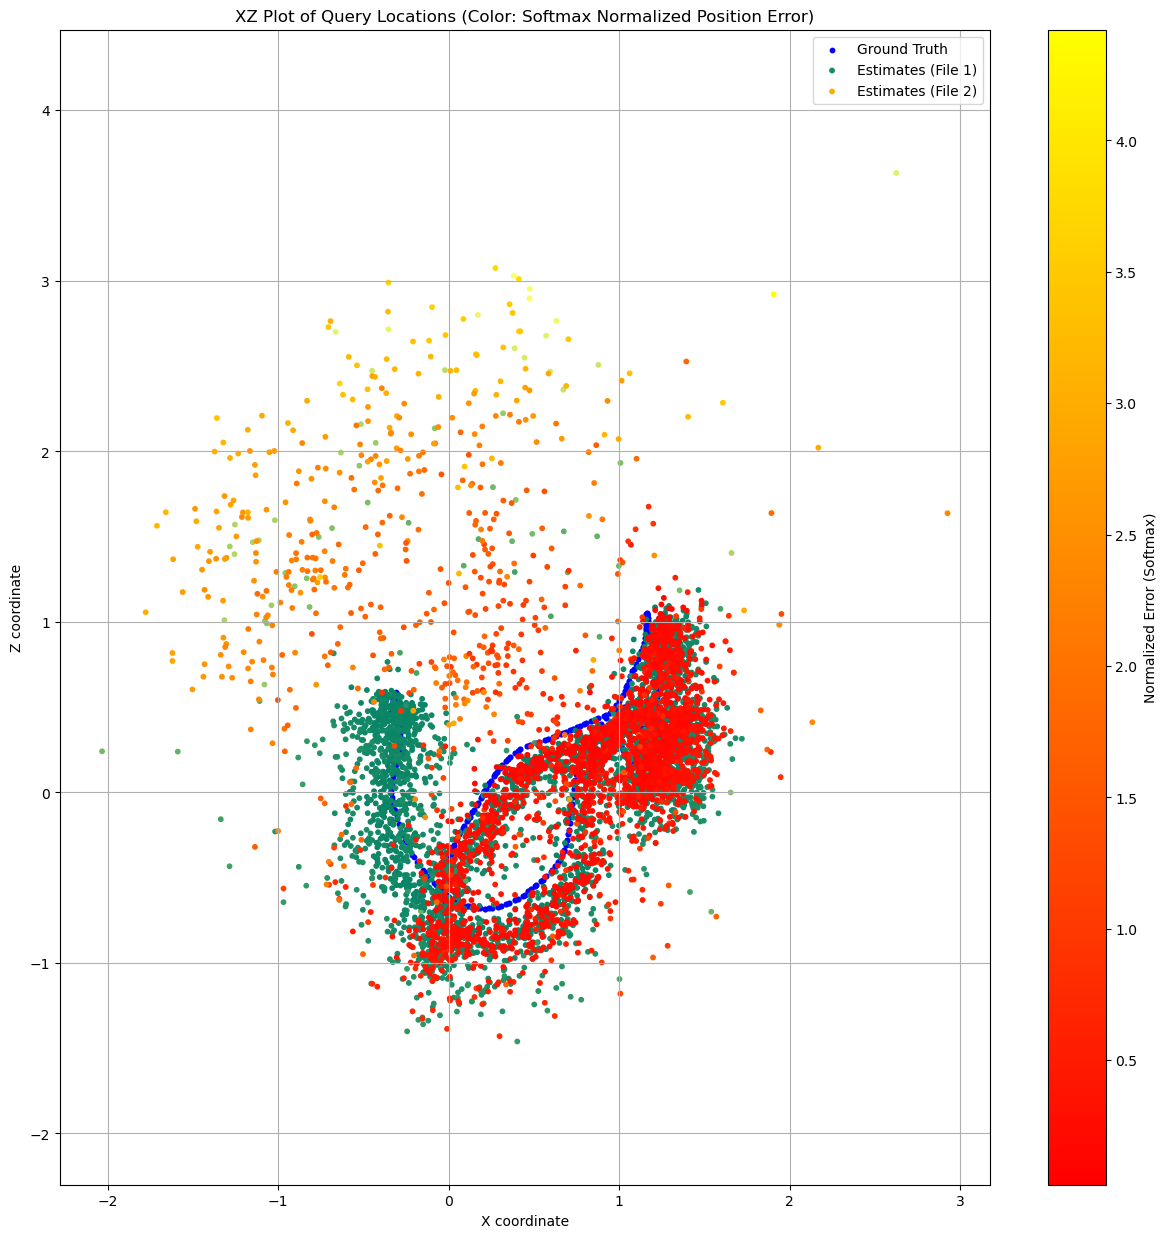

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.special import softmax

def plot_xz_locations_comparison(dataset, results_file1, results_file2, error_threshold):
    gt_x, gt_z = [], []
    est_x1, est_z1, pos_errors1 = [], [], []
    est_x2, est_z2, pos_errors2 = [], [], []
    
    def process_file(file_path, est_x, est_z, pos_errors):
        with open(file_path, 'r') as f:
            for query_idx, line in enumerate(tqdm(f, desc=f"Processing {file_path}")):
                chunks = line.strip().split()
                query_path = chunks[0]
                
                gt_pose = dataset._load_pose(query_path)
                gt_x.append(gt_pose[0, 3])
                gt_z.append(gt_pose[2, 3])
                
                for anchor_idx in range(9):
                    start_idx = 1 + anchor_idx * 32
                    end_idx = start_idx + 32
                    transform_and_pose = chunks[start_idx:end_idx]
                    
                    if not all(float(x) == 0 for x in transform_and_pose[16:]):
                        mast3r_query_pose = np.array([float(x) for x in transform_and_pose[16:]]).reshape(4, 4)
                        
                        est_x.append(mast3r_query_pose[0, 3])
                        est_z.append(mast3r_query_pose[2, 3])
                        
                        pos_error = np.linalg.norm(mast3r_query_pose[:3, 3] - gt_pose[:3, 3])
                        pos_errors.append(pos_error)
    
    process_file(results_file1, est_x1, est_z1, pos_errors1)
    process_file(results_file2, est_x2, est_z2, pos_errors2)
    
    print(f"Number of queries: {len(gt_x)}")
    print(f"Number of estimates (File 1): {len(est_x1)}")
    print(f"Number of estimates (File 2): {len(est_x2)}")
    print(f"Number of large errors (>{error_threshold}m) (File 1): {sum(e > error_threshold for e in pos_errors1)}")
    print(f"Number of large errors (>{error_threshold}m) (File 2): {sum(e > error_threshold for e in pos_errors2)}")
    
    plt.figure(figsize=(15, 15))

    
    # Apply softmax normalization
    def softmax_normalize(errors, temperature=1.0):
        return softmax(np.array(errors) / temperature)
    

    plt.scatter(gt_x, gt_z, c='blue', label='Ground Truth', alpha=1, s=10)
    plt.scatter(est_x1, est_z1, c=pos_errors1, cmap='summer', s=10, label='Estimates (File 1)')
    plt.scatter(est_x2, est_z2, c=pos_errors2, cmap='autumn', s=10, label='Estimates (File 2)')

    
    plt.colorbar(label='Normalized Error (Softmax)')
    plt.xlabel('X coordinate')
    plt.ylabel('Z coordinate')
    plt.title(f'XZ Plot of Query Locations (Color: Softmax Normalized Position Error)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Usage
error_threshold = 0.4
results_file1 = '/home/bjangley/VPR/7scenes/pairs2/results_dud2.txt'
results_file2 = '/home/bjangley/VPR/7scenes/pairs2/results_dud.txt'
plot_xz_locations_comparison(dataset, results_file1, results_file2, error_threshold)


In [ ]:
5